<a href="https://colab.research.google.com/github/satani99/fastai_22_2/blob/main/activations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fastai/course22p2.git
%cd course22p2

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (1176/1176), done.
remote: Compressing objects: 100% (480/480), done.
remote: Total 1176 (delta 712), reused 1117 (delta 694), pack-reused 0
Receiving objects: 100% (1176/1176), 99.81 MiB | 35.29 MiB/s, done.
Resolving deltas: 100% (712/712), done.
/content/course22p2


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 33.5 MB/s eta 0:00:00


In [4]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.7 MB/s eta 0:00:00


In [5]:
from __future__ import annotations
import random, math, torch, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [6]:
import torch.nn.functional as F, matplotlib as mpl
from pathlib import Path
from operator import attrgetter, itemgetter
from contextlib import contextmanager

from torch import tensor, nn, optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)


In [7]:
def set_seed(seed, deterministic=False):
  torch.use_deterministic_algorithms(deterministic)
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

In [8]:
x, y = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b):b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size =ks, padding=ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

def cnn_layers():
  return [
      conv(1, 8, ks=5),
      conv(8, 16),
      conv(16, 32),
      conv(32, 64),
      conv(64, 10, act=False),
      nn.Flatten(),
  ]

In [10]:
from torcheval.metrics import MulticlassAccuracy

In [11]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [12]:
def fit(model, epochs=1, xtra_cbs=None):
  learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
  learn.fit(epochs)
  return learn

accuracy,loss,epoch,train
0.138,2.305,0,train
0.332,2.248,0,eval


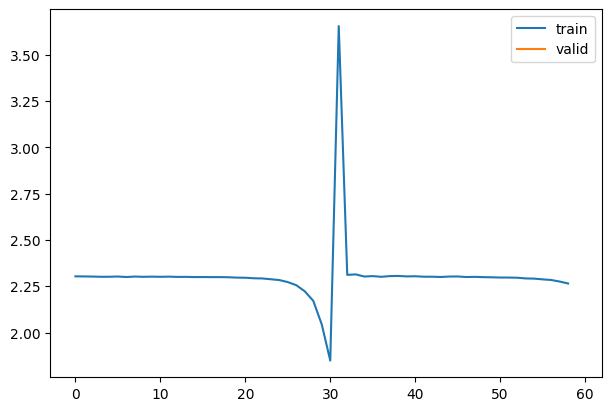

In [14]:
set_seed(42)
learn = fit(nn.Sequential(*cnn_layers()))

In [15]:
class SequentialModel(nn.Module):
  def __init__(self, *layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)
    self.act_means = [[] for _ in layers]
    self.act_stds = [[] for _ in layers]

  def __call__(self, x):
    for i,l in enumerate(self.layers):
      x = l(x)
      self.act_means[i].append(to_cpu(x).mean())
      self.act_stds[i].append(to_cpu(x).std())
    return x

  def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.138,2.305,0,train
0.332,2.248,0,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


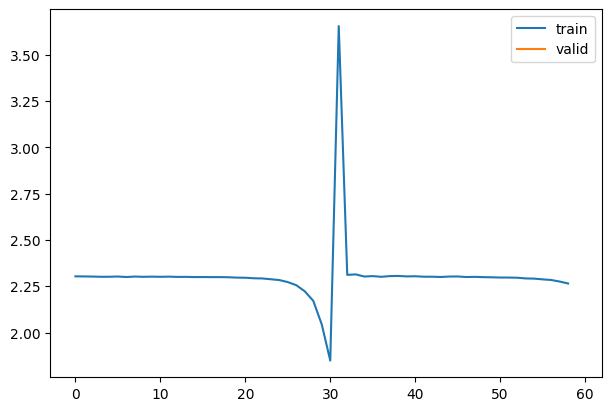

In [17]:
set_seed(42)
model = SequentialModel(*cnn_layers())
learn = fit(model)

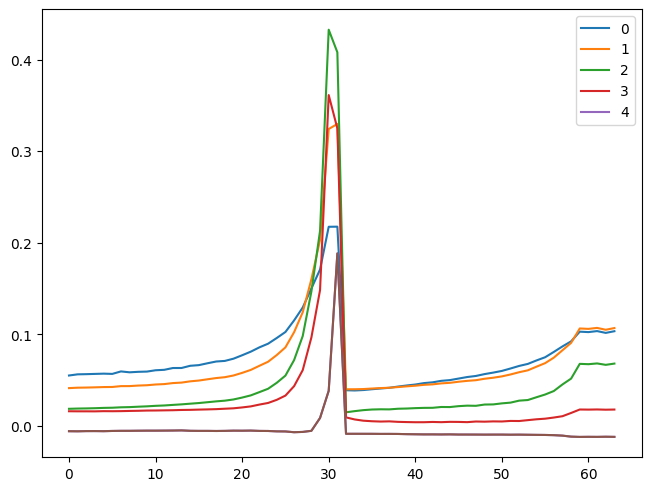

In [18]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

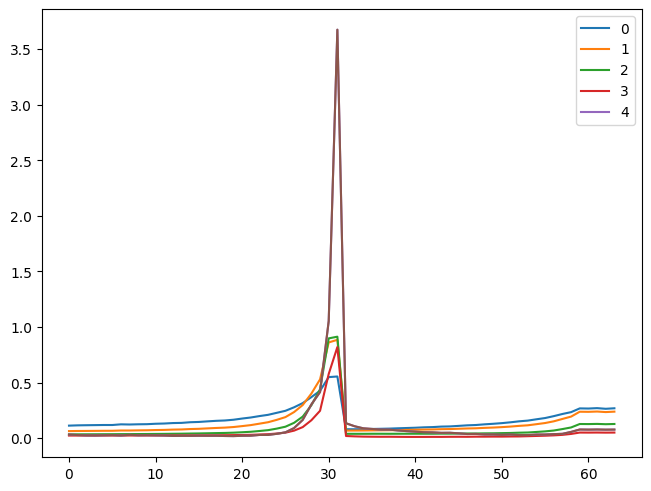

In [19]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

In [20]:
set_seed(42)
model = nn.Sequential(*cnn_layers())

In [21]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [22]:
def append_stats(i, mod, inp, outp):
  act_means[i].append(to_cpu(outp).mean())
  act_stds[i].append(to_cpu(outp).std())

In [27]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.138,2.305,0,train
0.332,2.248,0,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


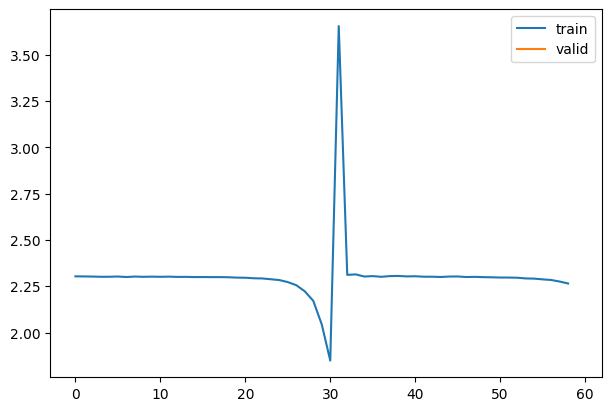

In [28]:
fit(model)